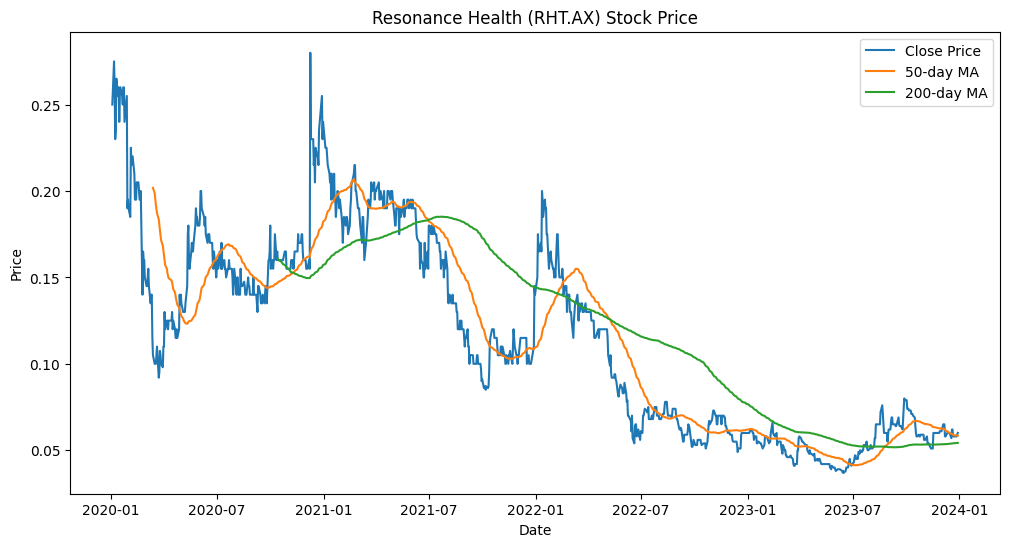

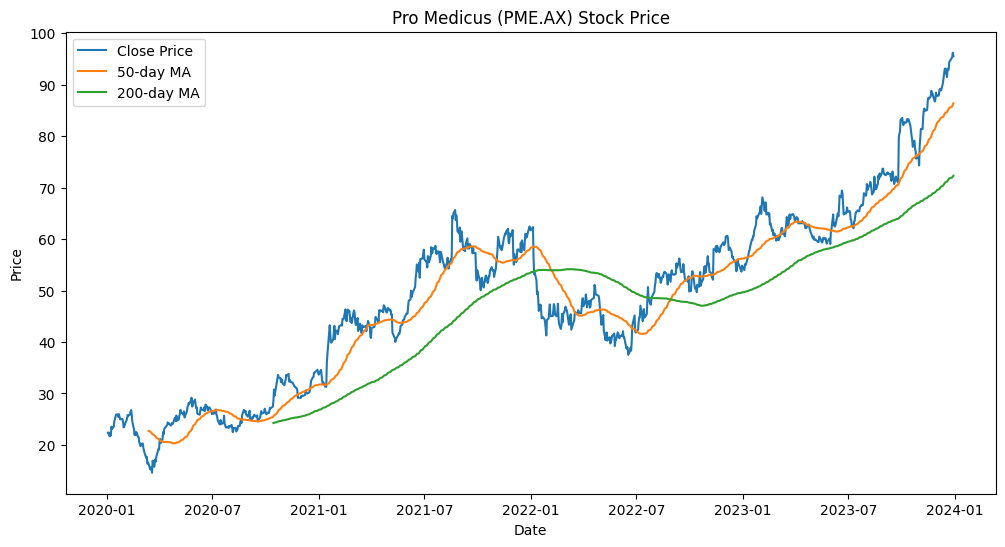

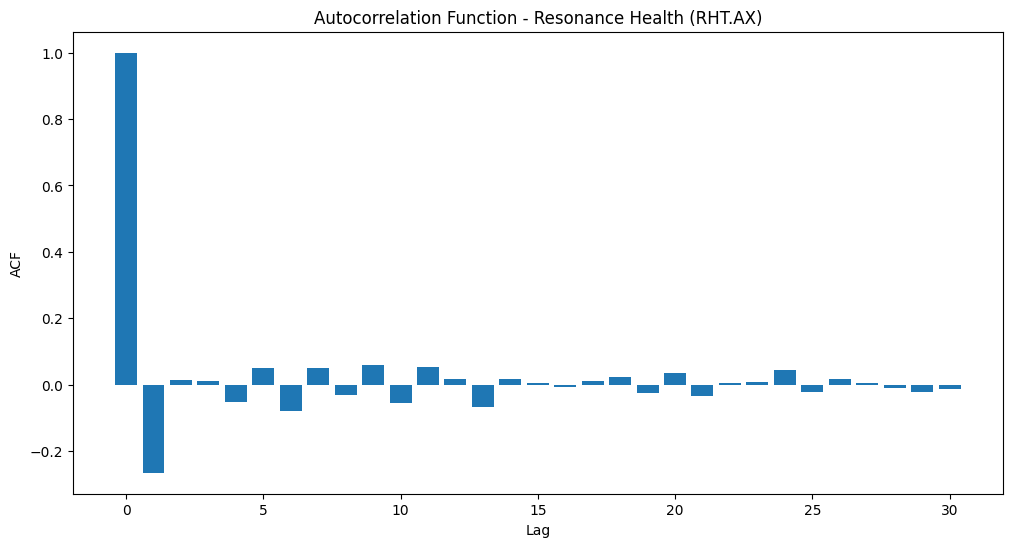

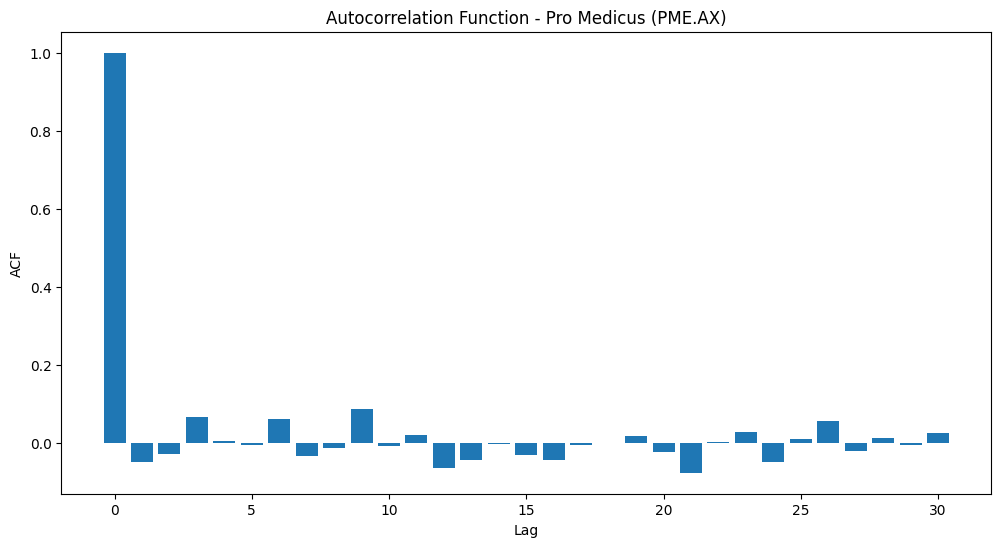

17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing


RHT ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1011
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3453.466
Date:                Wed, 23 Oct 2024   AIC                          -6900.932
Time:                        17:37:51   BIC                          -6886.178
Sample:                             0   HQIC                         -6895.327
                               - 1011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1007      0.090     -1.116      0.264      -0.278       0.076
ma.L1         -0.1778      0.090     -1.966      0.049      -0.355      -0.001
sigma2      6.274e-05   5.05e-07 

17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing


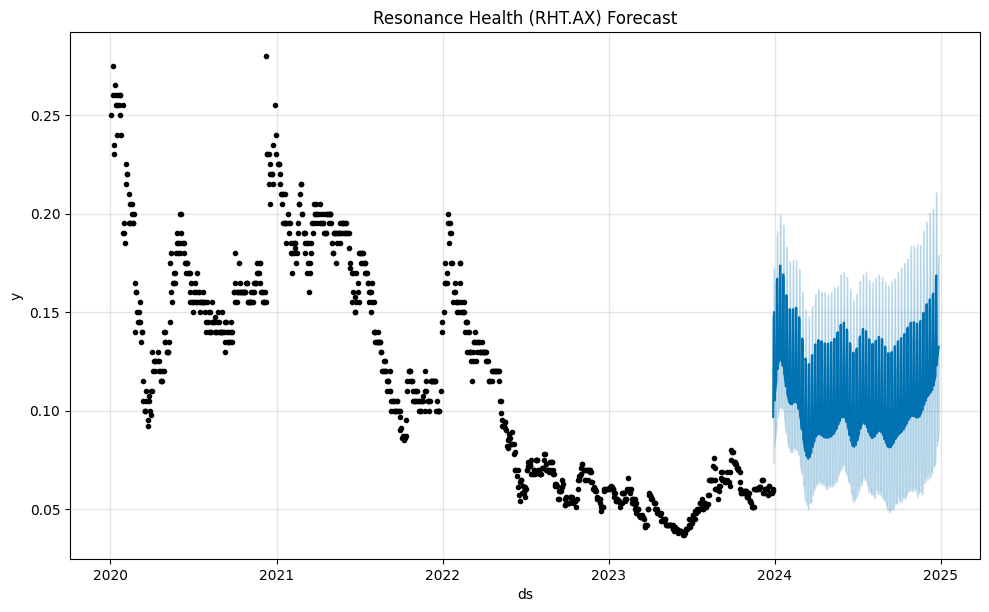

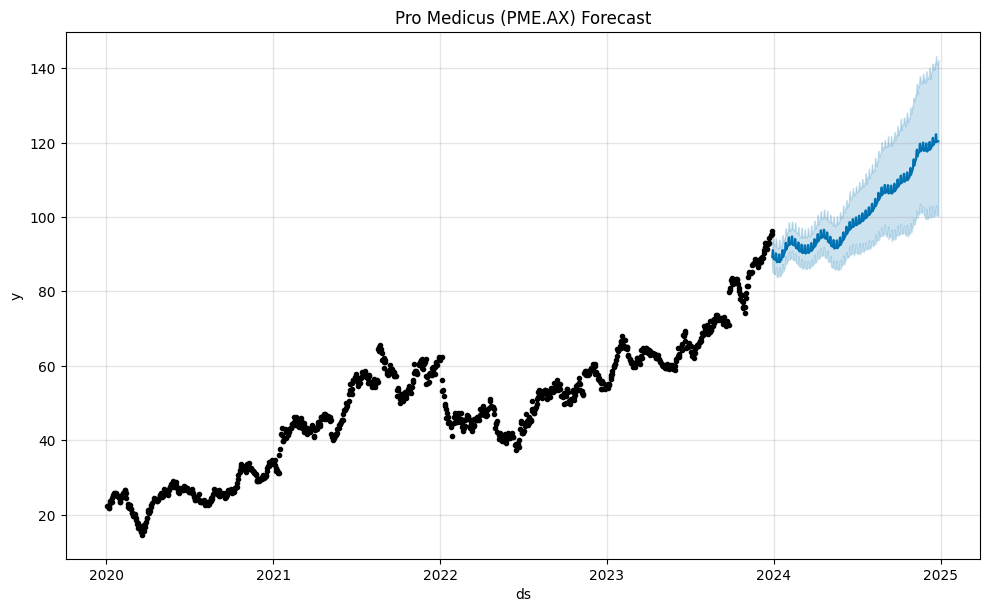


RHT Forecast Metrics:
MAE: 0.01
MSE: 0.00
RMSE: 0.02
R2: 0.89

PME Forecast Metrics:
MAE: 2.47
MSE: 9.15
RMSE: 3.02
R2: 0.97


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# データの取得
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df

# データの前処理
def preprocess_data(df):
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
    df.set_index('Date', inplace=True)
    df['Close_Prev'] = df['Close'].shift(1)
    df['Return'] = (df['Close'] - df['Close_Prev']) / df['Close_Prev']
    df['Open_Close_Diff'] = df['Close'] - df['Open']
    df['Differenced'] = df['Close'].diff()
    df = df.dropna()
    return df

# 移動平均の計算
def add_moving_average(df, window):
    df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

# データの可視化
def plot_stock_data(df, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['MA_50'], label='50-day MA')
    plt.plot(df.index, df['MA_200'], label='200-day MA')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 自己相関分析
def plot_autocorrelation(df, title):
    acf_values = acf(df['Differenced'])
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(acf_values)), acf_values)
    plt.title(f'Autocorrelation Function - {title}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()

# ARIMA モデル
def fit_arima_model(df):
    model = ARIMA(df['Close'], order=(1, 1, 1))
    results = model.fit()
    return results

# Prophet モデル
def fit_prophet_model(df):
    prophet_df = df['Close'].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet()
    model.fit(prophet_df)
    return model

# 予測評価指標の計算
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# メイン処理
if __name__ == "__main__":
    # データ取得
    rht_df = get_stock_data("RHT.AX", "2020-01-01", "2023-12-31")
    pme_df = get_stock_data("PME.AX", "2020-01-01", "2023-12-31")

    # データ前処理
    rht_df = preprocess_data(rht_df)
    pme_df = preprocess_data(pme_df)

    # 移動平均の追加
    rht_df = add_moving_average(rht_df, 50)
    rht_df = add_moving_average(rht_df, 200)
    pme_df = add_moving_average(pme_df, 50)
    pme_df = add_moving_average(pme_df, 200)

    # データ可視化
    plot_stock_data(rht_df, "Resonance Health (RHT.AX) Stock Price")
    plot_stock_data(pme_df, "Pro Medicus (PME.AX) Stock Price")

    # 自己相関分析
    plot_autocorrelation(rht_df, "Resonance Health (RHT.AX)")
    plot_autocorrelation(pme_df, "Pro Medicus (PME.AX)")

    # ARIMA モデル
    rht_arima = fit_arima_model(rht_df)
    pme_arima = fit_arima_model(pme_df)

    print("RHT ARIMA Summary:")
    print(rht_arima.summary())
    print("\nPME ARIMA Summary:")
    print(pme_arima.summary())

    # Prophet モデル
    rht_prophet = fit_prophet_model(rht_df)
    pme_prophet = fit_prophet_model(pme_df)

    # 将来予測
    future_dates = pd.date_range(start=rht_df.index[-1], periods=365)
    future_df = pd.DataFrame({'ds': future_dates})

    rht_forecast = rht_prophet.predict(future_df)
    pme_forecast = pme_prophet.predict(future_df)

    # 予測結果の可視化
    fig1 = rht_prophet.plot(rht_forecast)
    plt.title("Resonance Health (RHT.AX) Forecast")
    plt.show()

    fig2 = pme_prophet.plot(pme_forecast)
    plt.title("Pro Medicus (PME.AX) Forecast")
    plt.show()

    # 予測評価
    rht_mae, rht_mse, rht_rmse, rht_r2 = calculate_metrics(rht_df['Close'], rht_prophet.predict(rht_df['Close'].reset_index().rename(columns={'Date': 'ds'}))['yhat'])
    pme_mae, pme_mse, pme_rmse, pme_r2 = calculate_metrics(pme_df['Close'], pme_prophet.predict(pme_df['Close'].reset_index().rename(columns={'Date': 'ds'}))['yhat'])

    print("\nRHT Forecast Metrics:")
    print(f"MAE: {rht_mae:.2f}")
    print(f"MSE: {rht_mse:.2f}")
    print(f"RMSE: {rht_rmse:.2f}")
    print(f"R2: {rht_r2:.2f}")

    print("\nPME Forecast Metrics:")
    print(f"MAE: {pme_mae:.2f}")
    print(f"MSE: {pme_mse:.2f}")
    print(f"RMSE: {pme_rmse:.2f}")
    print(f"R2: {pme_r2:.2f}")


[*********************100%***********************]  1 of 1 completed
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing


Data loaded successfully for RHT.AX: 506 records
Prophet forecast completed for RHT.AX
ARIMA forecast completed for RHT.AX
Forecasts combined for RHT.AX


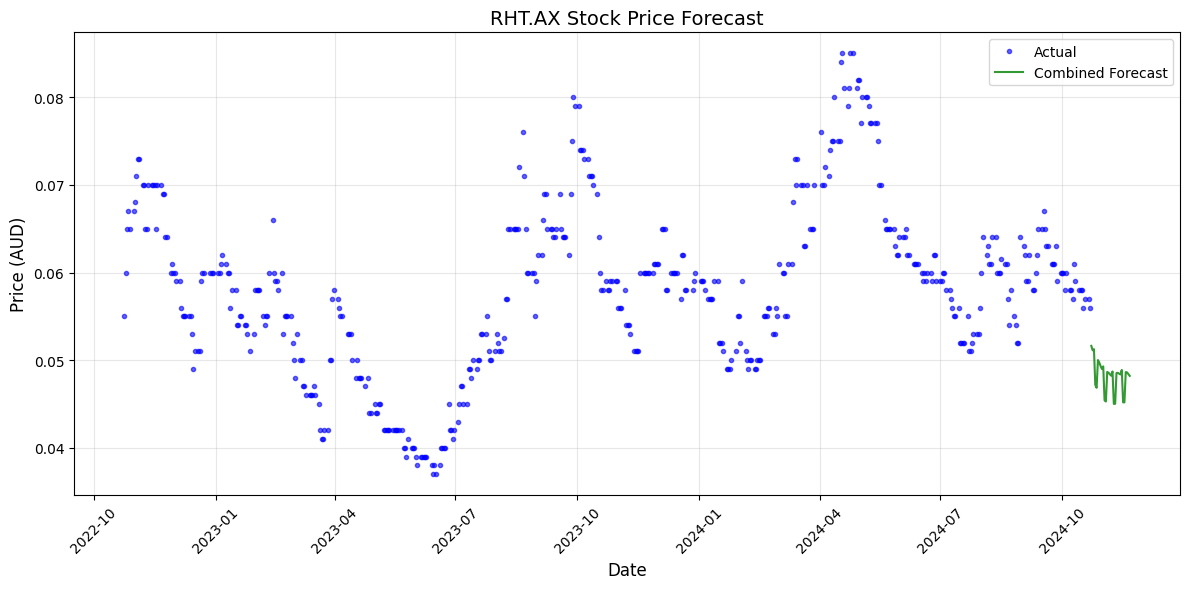

[*********************100%***********************]  1 of 1 completed

Data loaded successfully for PME.AX: 506 records



17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast completed for PME.AX
ARIMA forecast completed for PME.AX
Forecasts combined for PME.AX


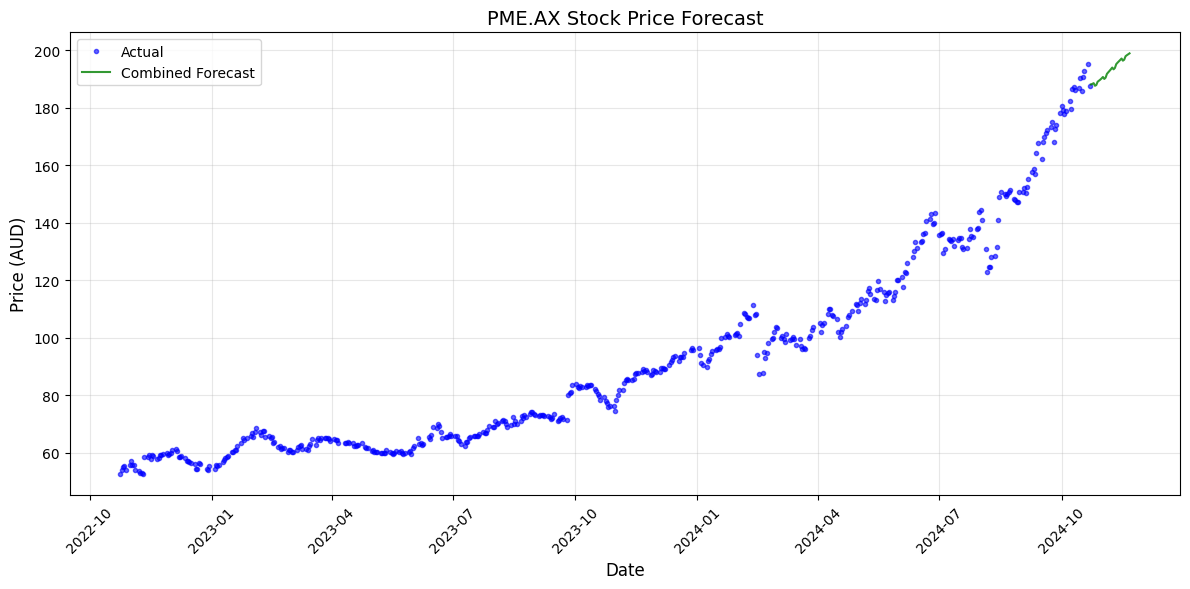

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

class StockPredictor:
    def __init__(self, ticker):
        # 銘柄コードを設定
        self.ticker = f"{ticker}.AX" if not ticker.endswith('.AX') else ticker
        self.data = None
        self.prophet_forecast = None
        self.arima_forecast = None
        self.combined_forecast = None

    def fetch_data(self, start_date=None, end_date=None):
        # データを取得する
        try:
            if not start_date:
                start_date = (datetime.now().replace(year=datetime.now().year - 2)).strftime('%Y-%m-%d')
            if not end_date:
                end_date = datetime.now().strftime('%Y-%m-%d')

            df = yf.download(self.ticker, start=start_date, end=end_date)
            
            if df.empty:
                raise ValueError(f"No data found for {self.ticker}")

            df = df.reset_index()
            self.data = pd.DataFrame({
                'ds': pd.to_datetime(df['Date']).dt.tz_localize(None),
                'y': df['Close'].astype(float).squeeze()
            })
            print(f"Data loaded successfully for {self.ticker}: {len(self.data)} records")
            return True

        except Exception as e:
            print(f"Error loading data for {self.ticker}: {str(e)}")
            return False

    def train_prophet(self, forecast_days=30):
        # Prophetモデルを訓練する
        try:
            model = Prophet(
                changepoint_prior_scale=0.1,
                seasonality_mode='additive',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False
            )

            model.fit(self.data)

            future_dates = model.make_future_dataframe(periods=forecast_days)
            self.prophet_forecast = model.predict(future_dates)
            
            print(f"Prophet forecast completed for {self.ticker}")
            return True

        except Exception as e:
            print(f"Error in Prophet prediction for {self.ticker}: {str(e)}")
            return False

    def train_arima(self, forecast_days=30):
        # ARIMAモデルを訓練する
        try:
            model = ARIMA(self.data['y'], order=(1, 1, 1))
            model_fit = model.fit()

            forecast = model_fit.forecast(steps=forecast_days)
            last_date = self.data['ds'].iloc[-1]
            future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
            self.arima_forecast = pd.DataFrame({'ds': future_dates, 'yhat': forecast})
            
            print(f"ARIMA forecast completed for {self.ticker}")
            return True

        except Exception as e:
            print(f"Error in ARIMA prediction for {self.ticker}: {str(e)}")
            return False

    def combine_forecasts(self):
        # 予測結果を組み合わせる
        try:
            combined = pd.merge(self.prophet_forecast[['ds', 'yhat']], 
                                self.arima_forecast, on='ds', suffixes=('_prophet', '_arima'))
            combined['yhat_combined'] = combined[['yhat_prophet', 'yhat_arima']].mean(axis=1)
            self.combined_forecast = combined
            print(f"Forecasts combined for {self.ticker}")
            return True

        except Exception as e:
            print(f"Error combining forecasts for {self.ticker}: {str(e)}")
            return False

    def plot_results(self):
        # 結果をプロットする
        try:
            plt.figure(figsize=(12, 6))
            plt.plot(self.data['ds'], self.data['y'], 'b.', label='Actual', alpha=0.6)
            plt.plot(self.combined_forecast['ds'], self.combined_forecast['yhat_combined'], 'g-', label='Combined Forecast', alpha=0.8)
            plt.title(f'{self.ticker} Stock Price Forecast', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Price (AUD)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in plotting for {self.ticker}: {str(e)}")

def main():
    # メイン関数
    tickers = ["RHT", "PME"]
    FORECAST_DAYS = 30

    for ticker in tickers:
        predictor = StockPredictor(ticker)
        
        if not predictor.fetch_data():
            continue

        if not predictor.train_prophet(FORECAST_DAYS):
            continue

        if not predictor.train_arima(FORECAST_DAYS):
            continue

        if not predictor.combine_forecasts():
            continue

        predictor.plot_results()

if __name__ == "__main__":
    main()

In [9]:
import yfinance as yf
import pandas as pd

# 財務データの取得
def get_financials(ticker):
    stock = yf.Ticker(ticker)
    balance_sheet = stock.balance_sheet
    income_statement = stock.financials
    cash_flow = stock.cashflow
    return balance_sheet, income_statement, cash_flow

# 財務データの表示
def display_financials(balance_sheet, income_statement, cash_flow):
    print("Balance Sheet:")
    print(balance_sheet)
    print("\nIncome Statement:")
    print(income_statement)
    print("\nCash Flow Statement:")
    print(cash_flow)

# 財務指標の計算
def calculate_financial_ratios(balance_sheet, income_statement):
    # 例: 流動比率の計算
    current_assets = balance_sheet.loc['Total Current Assets']
    current_liabilities = balance_sheet.loc['Total Current Liabilities']
    current_ratio = current_assets / current_liabilities
    print("\nCurrent Ratio:")
    print(current_ratio)

    # 例: 純利益率の計算
    net_income = income_statement.loc['Net Income']
    total_revenue = income_statement.loc['Total Revenue']
    profit_margin = net_income / total_revenue
    print("\nProfit Margin:")
    print(profit_margin)

# メイン処理
if __name__ == "__main__":
    # 2社のティッカーシンボル
    tickers = ["RHT.AX", "PME.AX"]

    for ticker in tickers:
        print(f"\nFinancials for {ticker}:")
        balance_sheet, income_statement, cash_flow = get_financials(ticker)
        display_financials(balance_sheet, income_statement, cash_flow)
        calculate_financial_ratios(balance_sheet, income_statement)


Financials for RHT.AX:
Balance Sheet:
                                                   2024-06-30   2023-06-30  \
Ordinary Shares Number                            446892928.0  461149601.0   
Share Issued                                      446892928.0  461149601.0   
Total Debt                                          3696402.0     272945.0   
Tangible Book Value                                 1067844.0    7221962.0   
Invested Capital                                   14104967.0    9935311.0   
...                                                       ...          ...   
Accounts Receivable                                 2350677.0    1104333.0   
Cash Cash Equivalents And Short Term Investments    6854820.0    6361622.0   
Cash And Cash Equivalents                           6854820.0    6361622.0   
Cash Equivalents                                    3450422.0    1037061.0   
Cash Financial                                      3404398.0    5324561.0   

                        

KeyError: 'Total Current Assets'